In [1]:
# # Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# # - this might take several minutes, so run these only if you haven't done so before.

# # load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py
# %run ../../core/event_numbers.py

# # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# # run these every time there are updates to resolution, binning, or mephistograms
# # load and prepare the energy and angular resolutions
# %run ../../core/resolution.py 
# #--renew_calc if you want to repeat the resolution generation (takes a few minutes)

# # gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

In [2]:
%load_ext autoreload
%autoreload 2

# Preparations

In [3]:
import mkl
mkl.set_num_threads(1)


48

# Imports

In [4]:
import pickle
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from tqdm import tqdm

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


In [5]:
# print TS significance levels
from settings import sigma3
from scipy.stats import chi2

print(f"{sigma3:1.3e}")
print(sigma5, sigma3)
print(chi2.sf(11.6, 1))
print(chi2.isf(0.05, 1))

6.749e-04
1.433257859617676e-07 0.0006749490158150517
0.0006595181936910385
3.8414588206941285


In [6]:
with open("../../local/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

# Settings

In [7]:
IC_North_det = "KM3NeT" # "P-ONE" # or 

In [8]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "IC + KM3NeT",
        "marker": "v",
    },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
    "Plenum-3": {
        "color": "purple",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-3",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "*",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [9]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

In [10]:
from matplotlib.colors import LogNorm

# Atmospheric background


In [11]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [12]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (501, 140);
False


In [13]:
# save for plotting script
with open(join(st.BASEPATH, "resources/baseline_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((baseline_eres.histo, baseline_eres.bins), f)

with open(join(st.BASEPATH, "resources/improved_energy_res_upgoing.pckl"), "wb") as f:
    pickle.dump((improved_eres.histo, improved_eres.bins), f)

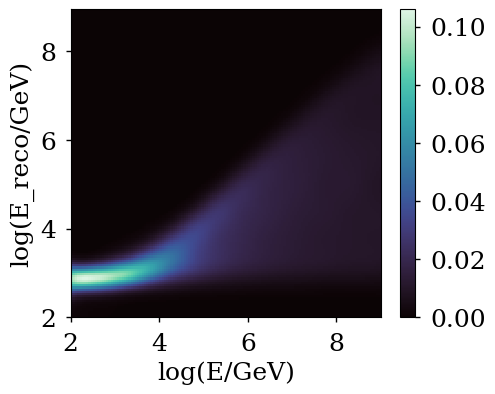

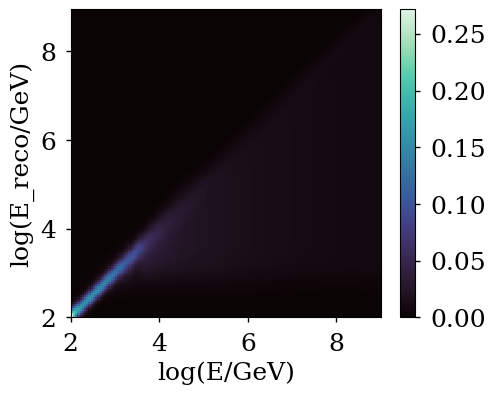

In [14]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [15]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

if False:
    with open(join(st.BASEPATH, "resources/energy_psi.pckl"), "wb") as f:
        pickle.dump((e_psi2_grid.histo, (e_psi2_grid.bins)), f)

Text(0.5, 0, '$\\Psi^2 = |\\Omega_{\\rm true} - \\Omega_{\\rm reco}|^2$')

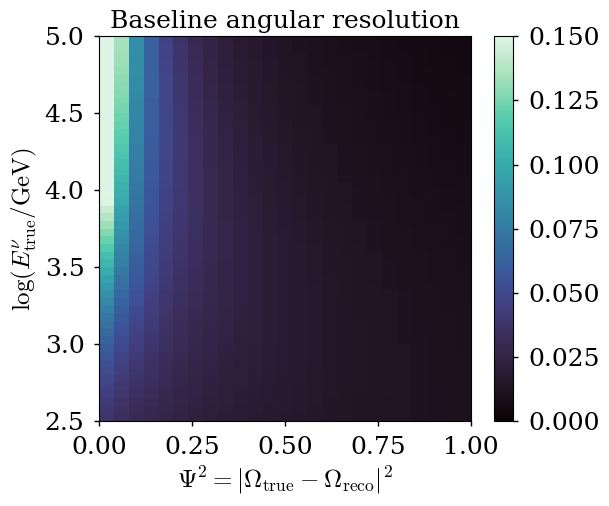

In [16]:

f, ax = plt.subplots(figsize=(6, 5))
ax.set_title("Baseline angular resolution")
f, ax = mephisto.plot_mephistogram(
    e_psi2_grid,
    f=f,
    ax=ax,  vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True, #norm=LogNorm()
)
ax.set_ylim(2.5, 5)
ax.set_xlim(0, 1)
ax.set_ylabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.set_xlabel(r"$\Psi^2 = |\Omega_{\rm true} - \Omega_{\rm reco}|^2$")

# NGC1068 and TXS 0506 source parameters

In [17]:
from fluxes import ngc_flux, ngc_cut_flux, txs_flux

In [18]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [19]:
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [20]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = st.txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = st.txs0506.dec.rad

_source = {
    "ngc": {"src_config": ngc_src_config, "bg_config": ngc_bg_config, "flux": ngc_flux},
    "txs": {"src_config": txs_src_config, "bg_config": txs_bg_config, "flux": txs_flux},
}

## Check event numbers

In [21]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))
bckg_flux = array_source_interp(
    ngc_bg_config["dec"],
    bckg_histo[ident],
    bckg_histo[ident].bin_mids[0],
    axis=1,
)
k_b = atmo_background(
    aeff_factor_bckg,
    bckg_flux,
    baseline_eres,
)
print("Bckg:", np.sum(k_b))

ngc 1068: 98.20825349645969
Bckg: 1488.281037312281


txs 0506+056: 5.581804873019875


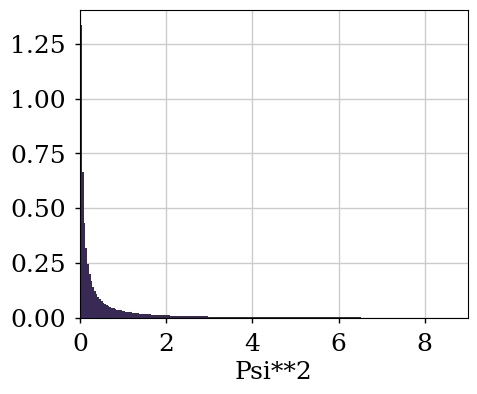

In [22]:

aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))

k_s.sum(axis=1, return_mephisto=True).plot()
#plt.gca().set_yscale("log")

In [23]:
ident = "P-ONE"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))

ngc 1068: 73.29554319399472


In [24]:
ident = "TRIDENT"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))

ngc 1068: 565.105220936199


### Plot 1D analysis slice histograms

In [25]:
## generate expected n_ev histograms for plotting
if False:
    local_background_flux = array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    np.savetxt(
        join(BASEPATH, "resources/local_background_ngc.txt"), local_background_flux
    )
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)  # 10 yr
    aeff_factor_signal = (
        calc_aeff_factor(aeff_2d[ident], **ngc_src_config) * 1.0
    )  # 10 yr

    for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                ngc_src_config["dec"],
                bckg_histo["IceCube"],
                bckg_histo["IceCube"].bin_mids[0],
                axis=1,
            ),
            energy_resolution=eres,
        )

        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_cut_flux,
        )
        np.savetxt(join(BASEPATH, f"resources/background_events_{e_name}.txt"), k_b)
        np.savetxt(join(BASEPATH, f"resources/PL_events_{e_name}.txt"), k_s_pl)
        np.savetxt(join(BASEPATH, f"resources/PLC_events_{e_name}.txt"), k_s_cut)

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# Analysis
## Significance test Background vs. Background + Signal

In [26]:
detector_keys = [
    "IceCube - data release",
    "IceCube",
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]

for eres, key, src_key in product([improved_eres], detector_keys, _source.keys()): #baseline_eres
    conf = st.detector_configurations[key]
    print(src_key)
    print(key)
    print(conf)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=_source[src_key]["flux"],
        bckg_histo=bckg_histo,
        bg_config=_source[src_key]["bg_config"],
        sig_config=_source[src_key]["src_config"],
        return_s_b=True,
    )
    print("signal events:", np.sum(all_k_s))

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=_source[src_key]["flux"].E0,
        phi_0=_source[src_key]["flux"].norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, _source[src_key]["flux"].gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, _source[src_key]["flux"].gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

ngc
IceCube - data release
(['IceCube'], [1])
signal events: 98.20825349645969
Atmo-only normalization: [1.06598067]
Signal fit parameters: [1.  1.  3.2]
TS check: -275756.1144771311 (fit:  -275756.1144771311 )
-2 Delta LLH: 23.29509398265509
P-VALUE: 8.740466527162343e-06 SIGNIFICANCE: 4.294852742135429

txs
IceCube - data release
(['IceCube'], [1])
signal events: 5.581804873019878
Atmo-only normalization: [1.00362022]
Signal fit parameters: [1. 1. 2.]
TS check: -222413.02975657742 (fit:  -222413.02975657742 )
-2 Delta LLH: 6.499044671654701
P-VALUE: 0.03879273330575147 SIGNIFICANCE: 1.7648708927342585

ngc
IceCube
(['IceCube'], [1.4])
signal events: 137.4915548950436
Atmo-only normalization: [1.06598813]
Signal fit parameters: [1.  1.  3.2]
TS check: -265232.94527680264 (fit:  -265232.94527680264 )
-2 Delta LLH: 32.61313147918554
P-VALUE: 8.282252764171431e-08 SIGNIFICANCE: 5.234262333395365

txs
IceCube
(['IceCube'], [1.4])
signal events: 7.814526822227825
Atmo-only normalization: [

## energy range

In [27]:
from likelihood import poisson_llh

ngc
IceCube
(['IceCube'], [1.4])
signal events: 137.4915548950436
Atmo-only normalization: [1.06598813]
txs
IceCube
(['IceCube'], [1.4])
signal events: 7.814526822227825
Atmo-only normalization: [1.00361981]
ngc
Plenum-1
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])
signal events: 456.5658367074521
Atmo-only normalization: [1.08833034]
txs
Plenum-1
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])
signal events: 20.336210259108125
Atmo-only normalization: [1.00392522]
ngc
Plenum-2
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])
signal events: 1094.9194844344402
Atmo-only normalization: [1.07376928]
txs
Plenum-2
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])
signal events: 56.61794193373733
Atmo-only normalization: [1.00372328]
ngc
Plenum-3
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])
signal events: 4603.8742860973325
Atmo-only normalization: [1.11544156]
txs
Plenum-3
(['IceCube

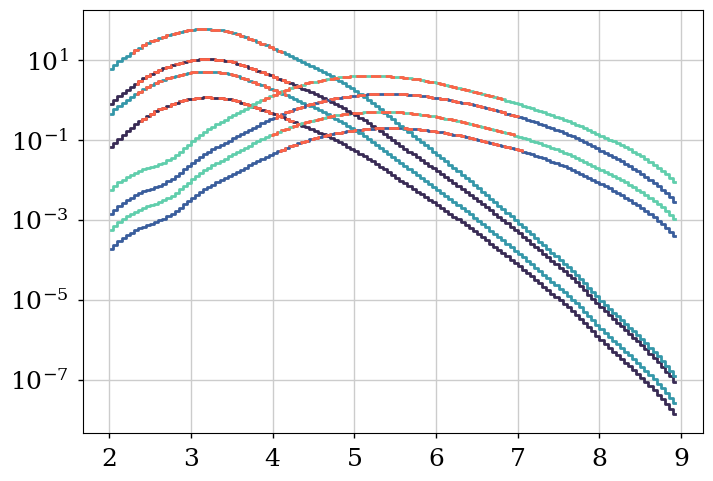

In [28]:
detector_keys = [
    "IceCube",
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]

for eres, key, src_key in product(
    [improved_eres], detector_keys, _source.keys()
):  # baseline_eres
    conf = st.detector_configurations[key]
    print(src_key)
    print(key)
    print(conf)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        eres=eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=_source[src_key]["flux"],
        bckg_histo=bckg_histo,
        bg_config=_source[src_key]["bg_config"],
        sig_config=_source[src_key]["src_config"],
        return_s_b=True,
    )
    print("signal events:", np.sum(all_k_s))

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=_source[src_key]["flux"].E0,
        phi_0=_source[src_key]["flux"].norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    signal_TS = np.array(
        [poisson_llh(all_k_i, all_k_i, summed=False) for all_k_i in all_k]
    )
    bckg_TS = np.array(
        [
            poisson_llh(all_kb_i * out_bckg[0], all_k_i, summed=False)
            for (all_kb_i, all_k_i) in zip(all_k_b, all_k)
        ]
    )
    # select the top contributing bins in energy to the final TS
    _idx = np.where(
        np.cumsum(np.sort(np.sum(bckg_TS - signal_TS, axis=(0, 1)))[::-1])
        / np.sum(bckg_TS - signal_TS)
        >= 0.9
    )[0][0]
    _top_idx = np.sort(np.argsort(np.sum(bckg_TS - signal_TS, axis=(0, 1)))[-_idx:])
    plt.figure(1)
    # plt.title(key)
    plt.plot(
        st.logE_reco_mids, np.sum(bckg_TS - signal_TS, axis=(0, 1)), ds="steps-mid"
    )
    plt.plot(
        st.logE_reco_mids[_top_idx],
        np.sum(bckg_TS - signal_TS, axis=(0, 1))[_top_idx],
        ds="steps-mid",
        color="tomato",
        ls="--",
        zorder=10,
    )
    plt.yscale("log")

(35.0, 41.0)

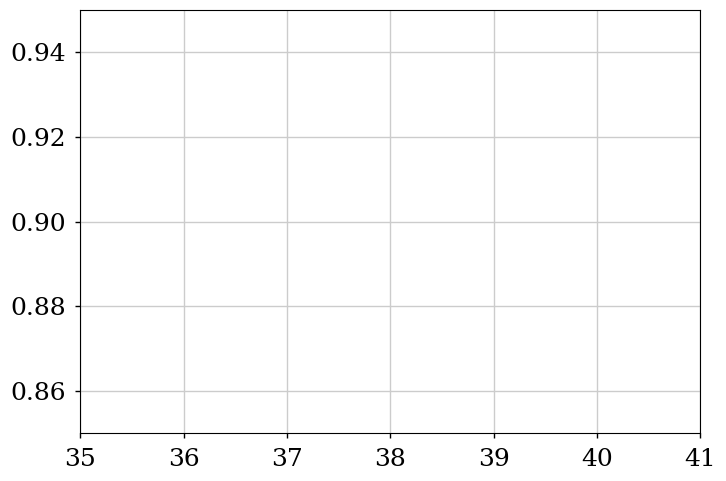

In [29]:
plt.plot(
    np.cumsum(np.sort(np.sum(bckg_TS - signal_TS, axis=(0, 1)))[::-1])
    / np.sum(bckg_TS - signal_TS),
    ds="steps-mid",
)
plt.ylim(0.85, 0.95)
plt.xlim(35, 41)

# 1D contours

In [30]:
detector_keys = ["IceCube - data release", "IceCube", IC_North_det, "Plenum-1", "Plenum-2", "Plenum-3"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.025

if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        if "Plenum-3" in ident:

            astro_scaling = np.arange(0.6, 1.45, step=step/5)
            gamma_astro = np.arange(2.85, 3.6, step=step/5)
        else:
            gamma_astro = np.arange(2.85, 3.6, step=step)
            astro_scaling = np.arange(0.6, 1.45, step=step)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_flux
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["Energy res."] = eres_key
        tmp["Detector"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["Flux normalization relative to baseline flux"] = out[0][1]
        tmp["Spectral index"] = out[0][2]
        tmp["fixed"] = "None"
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, aa in enumerate(astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, x[1]), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1, 2], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["Energy res."] = eres_key
            tmp["Detector"] = ident
            tmp["fixed"] = "Flux normalization relative to baseline flux"
            tmp["ts"] = local_out[1]
            tmp["$-2\Delta$ LLH"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["Flux normalization relative to baseline flux"] = aa
            tmp["Spectral index"] = local_out[0][1]
            tmp_SPL.append(tmp)

        for jj, gg in enumerate(gamma_astro):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], x[1], gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1, 1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["Energy res."] = eres_key
            tmp["Detector"] = ident
            tmp["fixed"] = "Spectral index"
            tmp["ts"] = local_out[1]
            tmp["$-2\Delta$ LLH"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["Spectral index"] = gg
            tmp["Flux normalization relative to baseline flux"] = local_out[0][1]
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_1D_contours_spl.pickle"))
else:
    SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_1D_contours_spl.pickle"))

IceCube - data release (['IceCube'], [1]) baseline
IceCube - data release (['IceCube'], [1]) improved
IceCube (['IceCube'], [1.4]) baseline
IceCube (['IceCube'], [1.4]) improved
KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) baseline
KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) improved
Plenum-3 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333]) baseline
Plenum-3 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333]) improved
info: IceCube - data release (['IceCube'], [1]) baseline
starting local fits...
info: IceCube - data release (['IceCube'], [1]) improved
starting local fits...
info: IceCube 

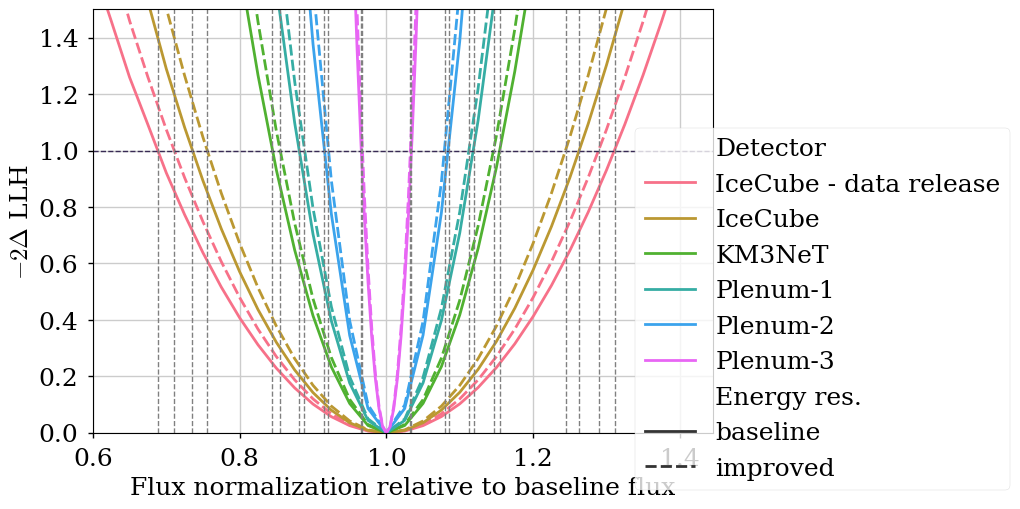

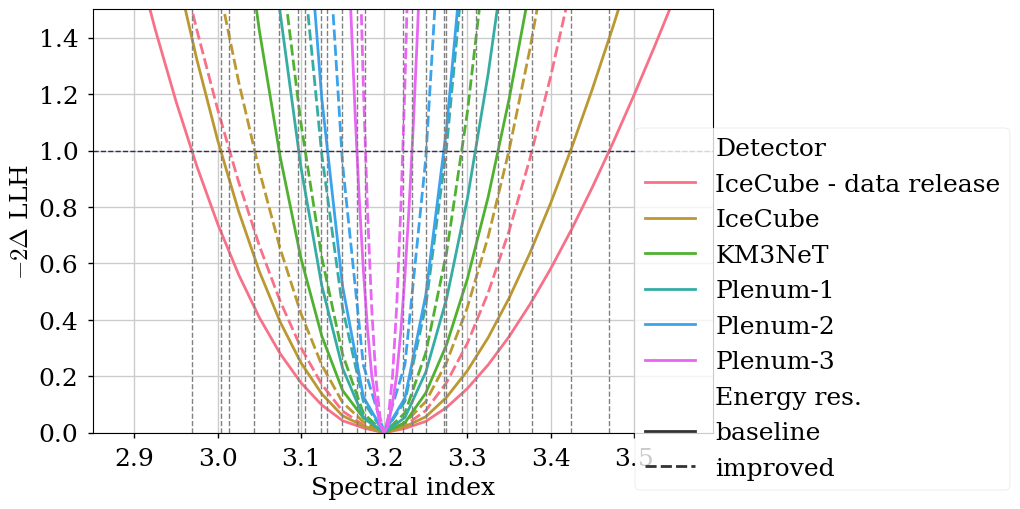

In [31]:
plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Flux normalization relative to baseline flux"]
sns.lineplot(
    data=selection,
    x="Flux normalization relative to baseline flux",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 1.5)
plt.xlim(astro_scaling[0], astro_scaling[-1])
plt.legend(
    bbox_to_anchor=(1.5, 0.75),
    loc=1,
)
plt.axhline(1, ls="--", lw=1)
norm_bounds = []
for (eres, det), series in selection.groupby(["Energy res.", "Detector"]):
    # spline
    # 1sigma bound on norm
    mask = series["Flux normalization relative to baseline flux"] < 1
    _spline = InterpolatedUnivariateSpline(
        series["Flux normalization relative to baseline flux"],
        series["$-2\Delta$ LLH"] - 1,
    )
    norm_plusminus = _spline.roots()
    plt.axvline(norm_plusminus[0], ls="--", lw=1, color="gray")
    plt.axvline(norm_plusminus[1], ls="--", lw=1, color="gray")
    norm_bounds.append(
        {
            "Energy res.": eres,
            "Detector": det,
            "norm_minus": norm_plusminus[0],
            "Delta_norm_minus": 1 - norm_plusminus[0],
            "Delta_norm_plus": norm_plusminus[1] - 1,
            "norm_plus": norm_plusminus[1],
            "norm_avg": 0.5 * (norm_plusminus[1] - norm_plusminus[0]),
            r"$ N= 1 \pm \sigma$": rf"${{}}^{{+{norm_plusminus[1] - 1:1.3f}}}_{{{norm_plusminus[0] - 1:1.3f}}}$",
            r"$ N= 1 \pm 1\sigma$": rf"$1 \pm {0.5 * (norm_plusminus[1] - norm_plusminus[0]):1.3f}$",
        }
    )
norm_bounds = pd.DataFrame(norm_bounds)


plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Spectral index"]
sns.lineplot(
    data=selection,
    x="Spectral index",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 1.5)
plt.xlim(gamma_astro[0], gamma_astro[-1])
plt.legend(
    bbox_to_anchor=(1.5, 0.75),
    loc=1,
)
plt.axhline(1, ls="--", lw=1)

gamma_bounds = []
for (eres, det), series in selection.groupby(["Energy res.", "Detector"]):
    # spline
    # 1sigma bound on gamma
    _spline = InterpolatedUnivariateSpline(
        series["Spectral index"],
        series["$-2\Delta$ LLH"] - 1,
    )
    gamma_plusminus = _spline.roots()  # 1 sigma lower bound
    plt.axvline(gamma_plusminus[0], ls="--", lw=1, color="gray")
    plt.axvline(gamma_plusminus[1], ls="--", lw=1, color="gray")
    gamma_bounds.append(
        {
            "Energy res.": eres,
            "Detector": det,
            "gamma_minus": gamma_plusminus[0],
            "Delta_gamma_minus": st.GAMMA_NGC - gamma_plusminus[0],
            "Delta_gamma_plus": gamma_plusminus[1] - st.GAMMA_NGC,
            "gamma_plus": gamma_plusminus[1],
            "gamma_avg": 0.5 * (gamma_plusminus[1] - gamma_plusminus[0]),
            rf"$\gamma = {st.GAMMA_NGC} \pm \sigma$": rf"${{}}^{{+{gamma_plusminus[1] - st.GAMMA_NGC:1.3f}}}_{{{gamma_plusminus[0] - st.GAMMA_NGC:1.3f}}}$",
            rf"$\gamma = {st.GAMMA_NGC} \pm 1\sigma$": rf"$3.2 \pm {0.5 * (gamma_plusminus[1] - gamma_plusminus[0]):1.3f}$",
        }
    )
gamma_bounds = pd.DataFrame(gamma_bounds)

In [32]:
parameter_bounds = (
    pd.merge(norm_bounds, gamma_bounds)[
        [
            "Energy res.",
            "Detector",
            "$ N= 1 \pm 1\sigma$",
            "$\gamma = 3.2 \pm 1\sigma$",
        ]
    ]
    .set_index(["Detector", "Energy res."])
    .sort_index()
)
parameter_bounds

$ N= 1 \pm 1\sigma$  \
Detector               Energy res.                       
IceCube                baseline          $1 \pm 0.264$   
                       improved          $1 \pm 0.244$   
IceCube - data release baseline          $1 \pm 0.311$   
                       improved          $1 \pm 0.289$   
KM3NeT                 baseline          $1 \pm 0.155$   
                       improved          $1 \pm 0.146$   
Plenum-1               baseline          $1 \pm 0.119$   
                       improved          $1 \pm 0.113$   
Plenum-2               baseline          $1 \pm 0.085$   
                       improved          $1 \pm 0.079$   
Plenum-3               baseline          $1 \pm 0.034$   
                       improved          $1 \pm 0.033$   

                                   $\gamma = 3.2 \pm 1\sigma$  
Detector               Energy res.                             
IceCube                baseline               $3.2 \pm 0.210$  
                       improved               $3.2 \pm 0.153$  
IceCube - data release baseline               $3.2 \pm 0.251$  
                       improved               $3.2 \pm 0.182$  
KM3NeT                 baseline               $3.2 \pm 0.132$  
                       improved               $3.2 \pm 0.095$  
Plenum-1               baseline               $3.2 \pm 0.107$  
                       improved               $3.2 \pm 0.075$  
Plenum-2               baseline               $3.2 \pm 0.071$  
                       improved               $3.2 \pm 0.051$  
Plenum-3               baseline               $3.2 \pm 0.033$  
                       improved               $3.2 \pm 0.023$

In [33]:
0.182 / 3.2,  0.023 / 3.2

(0.056874999999999995, 0.0071874999999999994)

In [34]:
print(parameter_bounds.to_latex(float_format="%.3f", sparsify=True))

\begin{tabular}{llll}
\toprule
 &  & $ N= 1 \pm 1\sigma$ & $\gamma = 3.2 \pm 1\sigma$ \\
Detector & Energy res. &  &  \\
\midrule
\multirow[t]{2}{*}{IceCube} & baseline & $1 \pm 0.264$ & $3.2 \pm 0.210$ \\
 & improved & $1 \pm 0.244$ & $3.2 \pm 0.153$ \\
\cline{1-4}
\multirow[t]{2}{*}{IceCube - data release} & baseline & $1 \pm 0.311$ & $3.2 \pm 0.251$ \\
 & improved & $1 \pm 0.289$ & $3.2 \pm 0.182$ \\
\cline{1-4}
\multirow[t]{2}{*}{KM3NeT} & baseline & $1 \pm 0.155$ & $3.2 \pm 0.132$ \\
 & improved & $1 \pm 0.146$ & $3.2 \pm 0.095$ \\
\cline{1-4}
\multirow[t]{2}{*}{Plenum-1} & baseline & $1 \pm 0.119$ & $3.2 \pm 0.107$ \\
 & improved & $1 \pm 0.113$ & $3.2 \pm 0.075$ \\
\cline{1-4}
\multirow[t]{2}{*}{Plenum-2} & baseline & $1 \pm 0.085$ & $3.2 \pm 0.071$ \\
 & improved & $1 \pm 0.079$ & $3.2 \pm 0.051$ \\
\cline{1-4}
\multirow[t]{2}{*}{Plenum-3} & baseline & $1 \pm 0.034$ & $3.2 \pm 0.033$ \\
 & improved & $1 \pm 0.033$ & $3.2 \pm 0.023$ \\
\cline{1-4}
\bottomrule
\end{tabular}



(2.85, 3.594999999999984)

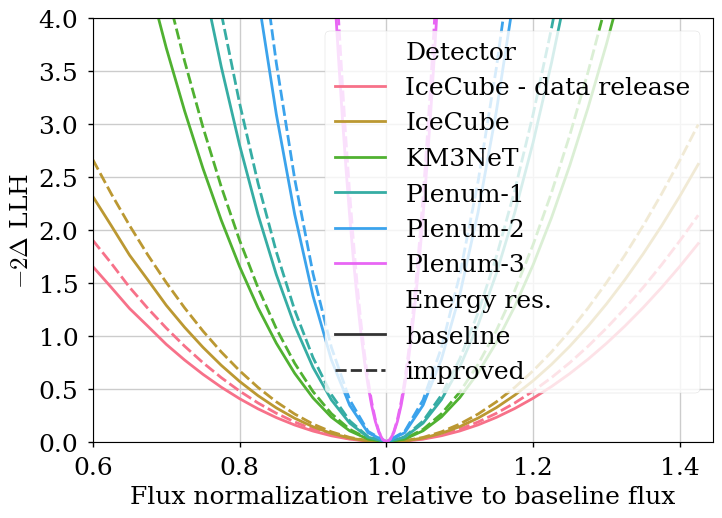

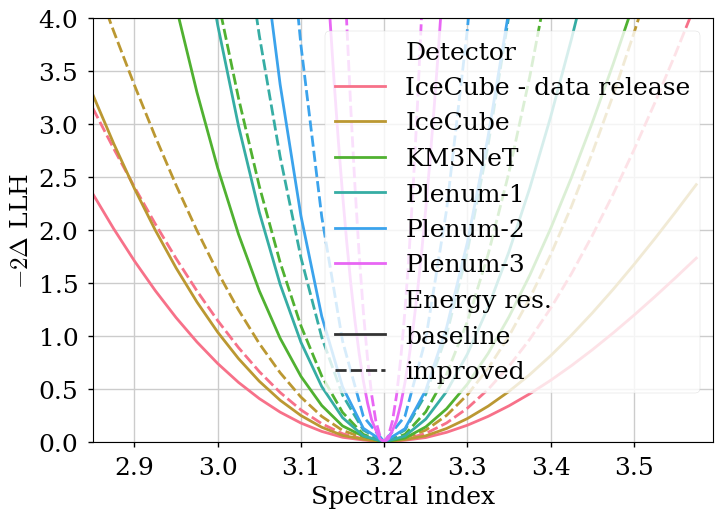

In [35]:
# plotting only
plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Flux normalization relative to baseline flux"]
sns.lineplot(
    data=selection,
    x="Flux normalization relative to baseline flux",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 4)
plt.xlim(astro_scaling[0], astro_scaling[-1])

plt.figure()
selection = SPL_df.loc[SPL_df.fixed == "Spectral index"]
sns.lineplot(
    data=selection,
    x="Spectral index",
    y="$-2\Delta$ LLH",
    hue="Detector",
    style="Energy res.",
)
plt.ylim(0, 4)
plt.xlim(gamma_astro[0], gamma_astro[-1])

# 2D contour
## Grid scan

In [36]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "-."},
    "IceCube - data release": {
        "colors": [st.poles["IceCube"]["color"]],
        "linestyles": "--",
    },
    IC_North_det: {"colors": [st.poles[IC_North_det]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
    "Plenum-3": {
        "colors": [st.poles["Plenum-3"]["color"]],
        "linestyles": st.poles["Plenum-3"]["ls"],
    },
}
detector_keys = [
    "IceCube - data release",
    "IceCube",
    IC_North_det,
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

IceCube - data release (['IceCube'], [1]) baseline
IceCube - data release (['IceCube'], [1]) improved
IceCube (['IceCube'], [1.4]) baseline
IceCube (['IceCube'], [1.4]) improved
KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) baseline
KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) improved
Plenum-3 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333]) baseline
Plenum-3 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333]) improved


In [37]:
energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.025

if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        if "Plenum-2" in ident:
            gamma_astro = np.arange(3, 3.4, step=step/2)
            astro_scaling = np.arange(0.8, 1.2, step=step/2)
        elif "Plenum-3" in ident:
            gamma_astro = np.arange(3.1, 3.3, step=step/5)
            astro_scaling = np.arange(0.9, 1.1, step=step/5)
        else:
            gamma_astro = np.arange(2.8, 3.7, step=step)
            astro_scaling = np.arange(0.5, 1.5, step=step)
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_flux
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["energy_res"] = eres_key
        tmp["ident"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["phi_astro"] = out[0][1]
        tmp["gamma"] = out[0][2]
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, (aa, gg) in enumerate(product(astro_scaling, gamma_astro)):
            # if jj%int(len(astro_scaling) * len(gamma_astro)/5) == 0: print("it", jj)
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["energy_res"] = eres_key
            tmp["ident"] = ident

            tmp["ts"] = local_out[1]
            tmp["delta_ts"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["phi_astro"] = aa
            tmp["gamma"] = gg
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))
    SPL_df.to_csv(join(BASEPATH, "resources/ngc_contour_spl.csv"))

info: IceCube - data release (['IceCube'], [1]) baseline
starting local fits...
info: IceCube - data release (['IceCube'], [1]) improved
starting local fits...
info: IceCube (['IceCube'], [1.4]) baseline
starting local fits...
info: IceCube (['IceCube'], [1.4]) improved
starting local fits...
info: KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) baseline
starting local fits...
info: KM3NeT (['IceCube', 'KM3NeT'], [2.4, 1]) improved
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) baseline
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1]) improved
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) baseline
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1]) improved
starting local fits...
info: Plenum-3 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])

In [38]:
import matplotlib

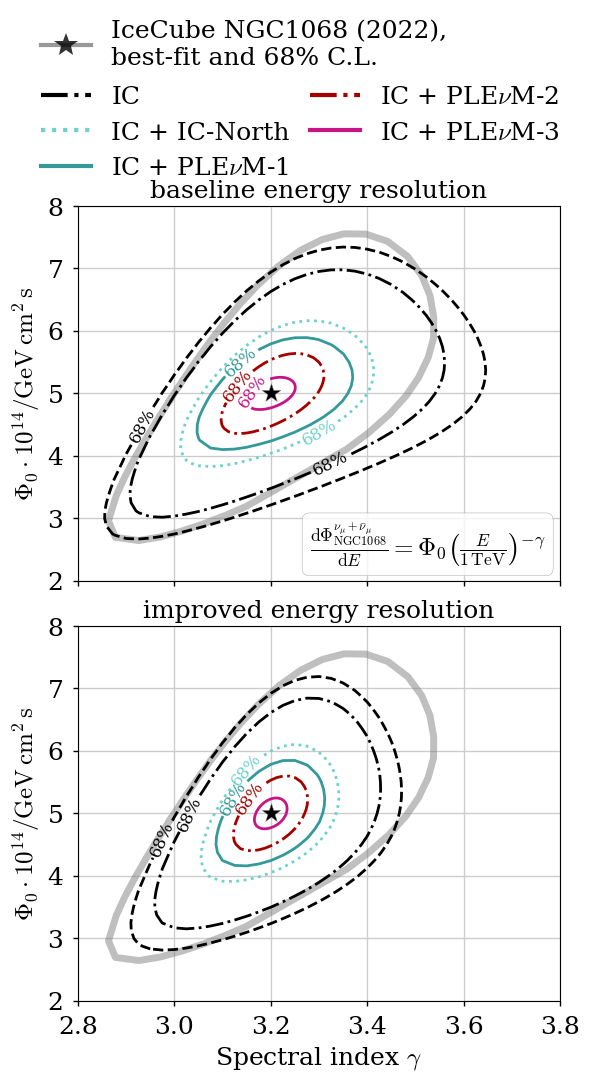

In [39]:
SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            zorder=10,
            **contour_formats[ident],
        )
        fmt = {l: s for l, s in zip(sc.levels, lbs)}
        ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="k",
        zorder=2,
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.8, 3.8)
    ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
    ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index $\gamma$")

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label="IceCube NGC1068 (2022),\nbest-fit and 68% C.L.",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats[IC_North_det]["colors"][0],
        ls=contour_formats[IC_North_det]["linestyles"],
        lw=3,
        label="IC + IC-North",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-2",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-3"]["colors"][0],
        ls=contour_formats["Plenum-3"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-3",
    ),
]
leg1 = f.legend(
    handles=[
        lines[0],
    ],
    loc="upper left",
    ncol=1,
    bbox_to_anchor=(0.04, 0.99),
    # fontsize="x-large",
    frameon=False,
)
f.legend(
    handles=lines[1:],
    loc="upper left",
    ncol=2,
    bbox_to_anchor=(0.04, 0.93),
    columnspacing=0.8,
    # fontsize="x-large",
    frameon=False,
)
# ax.add_artist(leg1)

flux_str = r"$\frac{{\rm d}\Phi_{\rm NGC 1068}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
for ax in axes:
    ax.text(
        0.97,
        0.07,
        flux_str,
        fontsize=18,
        transform=ax.transAxes,
        ha="right",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
    )
    break
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
f.subplots_adjust(top=0.8)

# f.savefig(join(BASEPATH, "plots/ngc_paper/2D_scan_ngc1068.pdf"))
# see plotting_standalone.ipynb for final version

# Disc. potential vs dec

### 3 sigma

In [40]:
# 3 sigma
thresholds = [sigma3]
detector_keys = [
    IC_North_det + "-only",
    "IceCube",
    IC_North_det,
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]
decs = np.sort(
    np.concatenate(
        [np.rad2deg(np.arcsin(np.linspace(-1, 1, 10))), np.linspace(-4.9, 0, num=5)]
    )
)
for src_key in _source:
    print(src_key)
    tmp = []  # save output here
    for ident in detector_keys:
        conf = st.detector_configurations[ident]
        print(conf)
        for dec in tqdm(np.deg2rad(decs)):
            if "IceCube" in ident and dec < np.deg2rad(-5):
                # skip the Southern Hemisphere
                continue

            # insert the declination into the configs
            cur_bg_conf = bg_config.copy()
            cur_bg_conf["dec"] = dec

            cur_sig_conf = src_config.copy()
            cur_sig_conf["dec"] = dec

            # set up all ingredients for the multi-sample likelihood calculation
            (
                all_aeff_factor_s,
                all_aeff_factor_b,
                all_k,
                all_bckg_flux,
                all_eres,
                all_k_b,
                all_k_s,
            ) = setup_multi_llh(
                energy_reso["improved"],  # select one resolution for all data sets
                conf,
                aeff_2d=aeff_2d,
                bckg_histo=bckg_histo,
                bg_config=cur_bg_conf,
                sig_config=cur_sig_conf,
                return_s_b=True,
                src_flux=_source[src_key]["flux"],
            )
            if np.isclose(np.sum(all_k_s), 0):
                continue
            # calculate an estimate for the flux scaling
            scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
            current_thresholds = copy(thresholds)
            count = 0

            # calculate the significance with various flux scalings to obtain
            # the 5-sigma discovery threshold by interpolation
            while len(current_thresholds) > 0:
                # scale the number of signal events - equivalent to scaling the flux
                current_k_s = [ks * scaler for ks in all_k_s]
                current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

                dct = dict(
                    shape="powerlaw",
                    all_aeff_factor_s=all_aeff_factor_s,
                    all_aeff_factor_b=all_aeff_factor_b,
                    all_k=current_k_i,
                    all_bckg_flux=all_bckg_flux,
                    all_eres=all_eres,
                    e_0=_source[src_key]["flux"].E0,
                    phi_0=_source[src_key]["flux"].norm,
                )
                # fix signal contribution to 0 for background fit
                local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
                global_llh = lambda x: ps_llh_multi(x, **dct)

                out_bckg = fmin_l_bfgs_b(
                    local_llh,
                    x0=(1,),
                    approx_grad=True,
                )

                out_comp = fmin_l_bfgs_b(
                    global_llh,
                    x0=(1, 1, _source[src_key]["flux"].gamma),
                    approx_grad=True,
                )
                pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
                tmp_dct = {
                    "ident": ident,
                    "dec": dec,
                    "scaler": scaler,
                    "cur_thresh": current_thresholds[0],
                    "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                    "n_b": np.sum(all_k_b),
                    "n_sig": np.sum(current_k_s),
                    "pval": pval,
                    "log10(p)": -np.log10(pval),
                }
                tmp.append(tmp_dct)
                tmp_df = pd.DataFrame(tmp)
                mask = (
                    (tmp_df.dec == dec)
                    & (tmp_df.ident == ident)
                    & (tmp_df.cur_thresh == current_thresholds[0])
                )
                scaler = scaling_estimation(
                    tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
                )

                if scaler == -1:
                    break

    df = pd.DataFrame(tmp)
    df.to_pickle(join(LOCALPATH, f"{src_key}_disc_pot_3sigma.pickle"))

ngc
(['KM3NeT'], [1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


end of range
end of range
end of range
(['IceCube'], [1.4])


 93%|█████████▎| 14/15 [00:02<00:00,  4.19it/s]

end of range
end of range
end of range


100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:06<00:00,  1.92it/s]

end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:15<00:01,  1.33s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:29<00:02,  2.10s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


txs
(['KM3NeT'], [1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


end of range
end of range
end of range
(['IceCube'], [1.4])


 93%|█████████▎| 14/15 [00:07<00:00,  1.32it/s]

end of range
end of range
end of range


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:16<00:01,  1.11s/it]

end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:26<00:01,  1.84s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:36<00:02,  2.32s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


  0%|          | 0/15 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 93%|█████████▎| 14/15 [00:34<00:02,  2.34s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


In [41]:
sns.set_palette("magma")

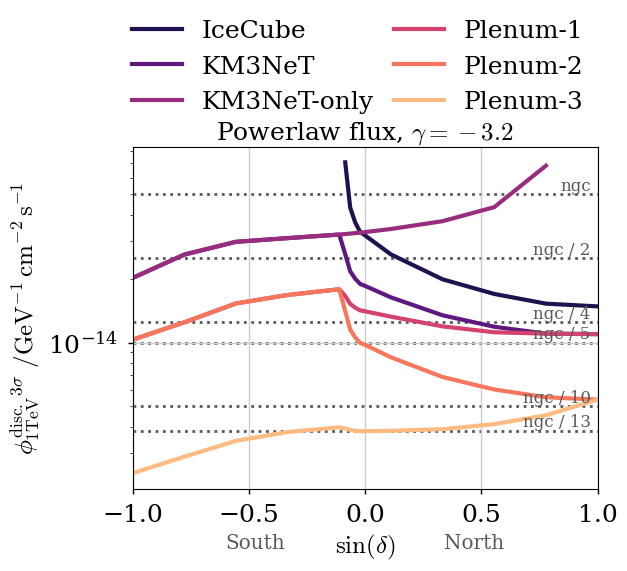

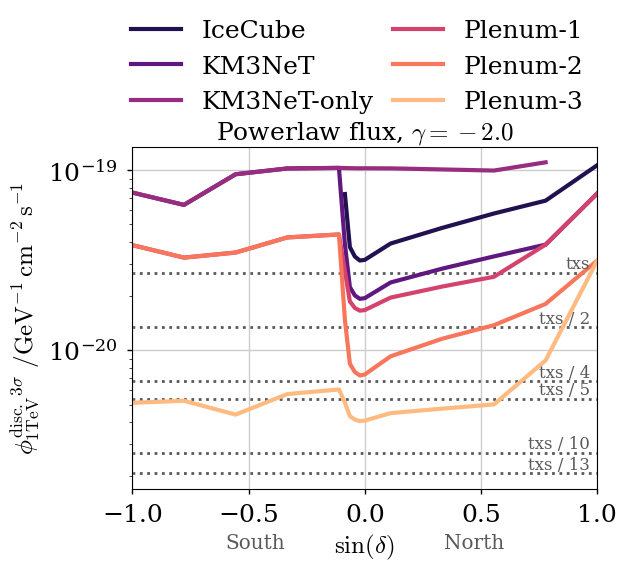

In [42]:
for src_key in _source:

    df = pd.read_pickle(join(LOCALPATH, f"{src_key}_disc_pot_3sigma.pickle"))
    flux = pd.DataFrame(
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
        * _source[src_key]["flux"].norm,
        columns=["disc3"],
    ).reset_index()
    flux["dec_deg"] = np.rad2deg(flux.dec)
    flux.to_pickle(join(BASEPATH, f"resources/flux_{src_key}_disc_pot_3sigma.pickle"))

    f, ax = plt.subplots(figsize=(6, 6))
    for ident, series in flux.groupby("ident"):
        plt.plot(
            np.sin(series.dec),
            series.disc3,
            lw=3,
            label=ident,
            # **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
        )
    ax.set_yscale("log")
    ax.set_xlabel(r"$\sin(\delta)$")
    ax.set_ylabel(
        r"$\phi^{\mathrm{disc.~3\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    )
    f.legend(
        loc="upper center",
        frameon=False,
        # fontsize=14,
        ncol=2,
        bbox_to_anchor=(0.5, 0.93),
        columnspacing=0.8,
    )
    # ax.set_ylim(None, 1e-13)
    ax.set_xlim(-1, 1)
    font_color = "0.35"
    for ii in [1, 2, 4, 5, 10, 13]:
        ax.axhline(
            _source[src_key]["flux"].norm / ii, ls=":", lw=2, color=font_color, zorder=0
        )
        ax.text(
            x=0.97,
            y=_source[src_key]["flux"].norm / ii,
            va="bottom",
            s=src_key if ii == 1 else f"{src_key} / {ii}",
            color=font_color,
            fontsize="large",
            ha="right",
        )
    ax.text(
        0.2,
        -0.175,
        "South",
        fontsize="x-large",
        color=font_color,
        transform=ax.transAxes,
    )
    ax.text(
        0.8,
        -0.175,
        "North",
        ha="right",
        fontsize="x-large",
        color=font_color,
        transform=ax.transAxes,
    )

    f.subplots_adjust(top=0.68)
    ax.set_title(rf"Powerlaw flux, $\gamma=-{_source[src_key]['flux'].gamma}$")

    # see plotting_standalone.ipynb for final version

### 5 sigma

In [43]:
# standard
thresholds = [sigma5]
detector_keys = [
    IC_North_det + "-only",
    "IceCube",
    IC_North_det,
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]
decs = np.sort(
    np.concatenate(
        [np.rad2deg(np.arcsin(np.linspace(-1, 1, 30))), np.linspace(-4.9, 0, num=5)]
    )
)
for src_key in _source:
    print(src_key)
    tmp = []  # save output here
    for ident in detector_keys:
        conf = st.detector_configurations[ident]
        print(conf)
        for dec in tqdm(np.deg2rad(decs)):
            if "IceCube" in ident and dec < np.deg2rad(-5):
                # skip the Southern Hemisphere
                continue

            # insert the declination into the configs
            cur_bg_conf = bg_config.copy()
            cur_bg_conf["dec"] = dec

            cur_sig_conf = src_config.copy()
            cur_sig_conf["dec"] = dec

            # set up all ingredients for the multi-sample likelihood calculation
            (
                all_aeff_factor_s,
                all_aeff_factor_b,
                all_k,
                all_bckg_flux,
                all_eres,
                all_k_b,
                all_k_s,
            ) = setup_multi_llh(
                energy_reso["improved"],  # select one resolution for all data sets
                conf,
                aeff_2d=aeff_2d,
                bckg_histo=bckg_histo,
                bg_config=cur_bg_conf,
                sig_config=cur_sig_conf,
                return_s_b=True,
                src_flux=_source[src_key]["flux"],
            )
            if np.isclose(np.sum(all_k_s), 0):
                continue
            # calculate an estimate for the flux scaling
            scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
            current_thresholds = copy(thresholds)
            count = 0

            # calculate the significance with various flux scalings to obtain
            # the 5-sigma discovery threshold by interpolation
            while len(current_thresholds) > 0:
                # scale the number of signal events - equivalent to scaling the flux
                current_k_s = [ks * scaler for ks in all_k_s]
                current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

                dct = dict(
                    shape="powerlaw",
                    all_aeff_factor_s=all_aeff_factor_s,
                    all_aeff_factor_b=all_aeff_factor_b,
                    all_k=current_k_i,
                    all_bckg_flux=all_bckg_flux,
                    all_eres=all_eres,
                    e_0=_source[src_key]["flux"].E0,
                    phi_0=_source[src_key]["flux"].norm,
                )
                # fix signal contribution to 0 for background fit
                local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
                global_llh = lambda x: ps_llh_multi(x, **dct)

                out_bckg = fmin_l_bfgs_b(
                    local_llh,
                    x0=(1,),
                    approx_grad=True,
                )

                out_comp = fmin_l_bfgs_b(
                    global_llh,
                    x0=(1, 1, _source[src_key]["flux"].gamma),
                    approx_grad=True,
                )
                pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
                tmp_dct = {
                    "ident": ident,
                    "dec": dec,
                    "scaler": scaler,
                    "cur_thresh": current_thresholds[0],
                    "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                    "n_b": np.sum(all_k_b),
                    "n_sig": np.sum(current_k_s),
                    "pval": pval,
                    "log10(p)": -np.log10(pval),
                }
                tmp.append(tmp_dct)
                tmp_df = pd.DataFrame(tmp)
                mask = (
                    (tmp_df.dec == dec)
                    & (tmp_df.ident == ident)
                    & (tmp_df.cur_thresh == current_thresholds[0])
                )
                scaler = scaling_estimation(
                    tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
                )

                if scaler == -1:
                    break

    df = pd.DataFrame(tmp)
    df.to_pickle(join(LOCALPATH, f"{src_key}_disc_pot.pickle"))

ngc
(['KM3NeT'], [1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range


100%|██████████| 35/35 [00:08<00:00,  3.93it/s]


end of range
end of range
end of range
(['IceCube'], [1.4])


 97%|█████████▋| 34/35 [00:04<00:00,  5.03it/s]

end of range
end of range
end of range


100%|██████████| 35/35 [00:04<00:00,  7.20it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:13<00:00,  2.34it/s]

end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:13<00:00,  2.52it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:28<00:00,  1.40it/s]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:28<00:00,  1.26it/s]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:43<00:01,  1.07s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:44<00:00,  1.26s/it]


txs
(['KM3NeT'], [1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range


100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


end of range
end of range
end of range
(['IceCube'], [1.4])


 97%|█████████▋| 34/35 [00:11<00:00,  1.70it/s]

end of range
end of range
end of range


100%|██████████| 35/35 [00:12<00:00,  2.90it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:33<00:00,  1.02it/s]

end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:59<00:01,  1.63s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [01:00<00:00,  1.73s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:58<00:01,  1.34s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [01:00<00:00,  1.72s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [01:14<00:01,  1.68s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [01:15<00:00,  2.16s/it]


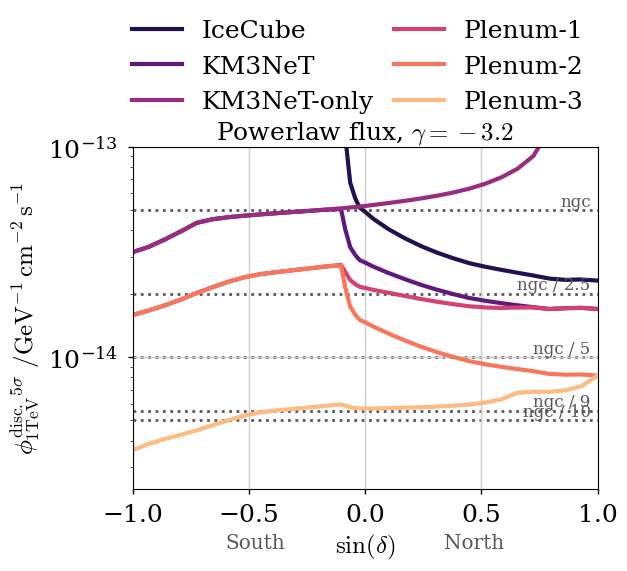

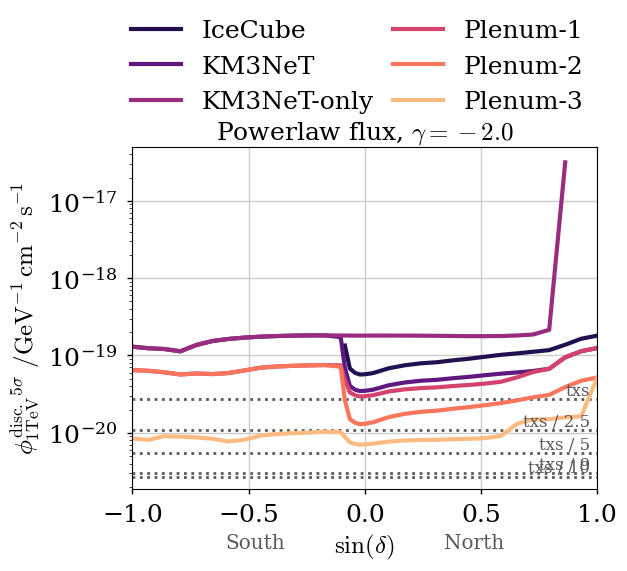

In [44]:
for src_key in _source:

    df = pd.read_pickle(join(LOCALPATH, f"{src_key}_disc_pot.pickle"))
    flux = pd.DataFrame(
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5))
        * _source[src_key]["flux"].norm,
        columns=["disc5"],
    ).reset_index()
    flux["dec_deg"] = np.rad2deg(flux.dec)
    flux.to_pickle(join(BASEPATH, f"resources/flux_{src_key}_disc_pot.pickle"))

    f, ax = plt.subplots(figsize=(6, 6))
    for ident, series in flux.groupby("ident"):
        plt.plot(
            np.sin(series.dec),
            series.disc5,
            lw=3,
            label=ident,
            # **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
        )
    ax.set_yscale("log")
    ax.set_xlabel(r"$\sin(\delta)$")
    ax.set_ylabel(
        r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    )
    f.legend(
        loc="upper center",
        frameon=False,
        # fontsize=14,
        ncol=2,
        bbox_to_anchor=(0.5, 0.93),
        columnspacing=0.8,
    )
    # ax.set_ylim(None, 1e-13)
    ax.set_xlim(-1, 1)
    font_color = "0.35"
    for ii in [1, 2.5, 5, 9, 10]:
        ax.axhline(
            _source[src_key]["flux"].norm / ii, ls=":", lw=2, color=font_color, zorder=0
        )
        ax.text(
            x=0.97,
            y=_source[src_key]["flux"].norm / ii,
            va="bottom",
            s=src_key if ii == 1 else f"{src_key} / {ii}",
            color=font_color,
            fontsize="large",
            ha="right",
        )
    ax.text(
        0.2,
        -0.175,
        "South",
        fontsize="x-large",
        color=font_color,
        transform=ax.transAxes,
    )
    ax.text(
        0.8,
        -0.175,
        "North",
        ha="right",
        fontsize="x-large",
        color=font_color,
        transform=ax.transAxes,
    )
    if src_key == "ngc":
        ax.set_ylim(None, 1e-13)
    f.subplots_adjust(top=0.68)
    ax.set_title(rf"Powerlaw flux, $\gamma=-{_source[src_key]['flux'].gamma}$")

    # see plotting_standalone.ipynb for final version

# Power law vs. Power-law with cutoff


In [45]:
identifier = "IceCube"
conf = (['IceCube'], [1.4]) # 14 yr

(
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_k,
    all_bckg_flux,
    all_eres,
) = setup_multi_llh(
    improved_eres,  # select one resolution for all data sets
    conf,
    aeff_2d=aeff_2d,
    bckg_histo=bckg_histo,
    bg_config=ngc_bg_config,
    sig_config=ngc_src_config,
    src_flux=ngc_cut_flux,
)

dct = dict(
    all_aeff_factor_s=all_aeff_factor_s,
    all_aeff_factor_b=all_aeff_factor_b,
    all_k=all_k,
    all_bckg_flux=all_bckg_flux,
    all_eres=all_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
)
pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
out_bckg = fmin_l_bfgs_b(
    pl_func,
    x0=(1.2, 1.2, 3.0),
    bounds=[(1E-3, 100), (1E-3, 100), (0.1, 5)],
    approx_grad=True,
)
print("powerlaw params:", out_bckg[0])

comp = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
out_comp = fmin_l_bfgs_b(
    comp,
    x0=(1.2, 1.1, 1.9, 3.4),
    bounds=[(1E-3, 100), (1E-3, 100), (0.1, 5), (1, 10)],
    approx_grad=True,
)
print("global params:", out_comp[0])
print("true params:", (1, 1, st.Gamma_cut, st.logE_cut))

# check the LLH at the "correct" parameter position
check = comp((1, 1, st.Gamma_cut, st.logE_cut))
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
pval_check = chi2.sf(out_bckg[1] - check, 1)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("pval check:", pval_check, "ratio:", pval_check / pval)
print("")

powerlaw params: [0.99864129 1.00313639 3.14083955]
global params: [0.99965385 1.71078048 2.07865833 3.43754781]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.012378713088155397 SIGNIFICANCE: 2.2451668060310723
pval check: 1.0 ratio: 80.78384181606508



## normal vs. improved E resolution

In [46]:
idents = ["IceCube", IC_North_det, "Plenum-1", "Plenum-2", "Plenum-3"]
detector_conf = [{"key": k, "identifier": det_plotting[k]["label"]} for k in idents]

eres_conf = (
    {"e_file": e_res_files["baseline"], "e_name": "Baseline"},
    {"e_file": e_res_files["1:1"], "e_name": "Removed bias"},
    #{"e_file": e_res_files["improved-20"], "e_name": "20% improv."},
    {"e_file": e_res_files["improved-50"], "e_name": "50% improv."},
)
# livetime relative to 10yrs

eres_detector_configurations = []
for dc, eresc in product(detector_conf, eres_conf):
    eres_detector_configurations.append(dc | eresc)
eres_detector_configurations = pd.DataFrame(eres_detector_configurations)

eres_detector_configurations

,key,identifier,e_file,e_name
0,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
1,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
2,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
3,KM3NeT,IC + KM3NeT,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
4,KM3NeT,IC + KM3NeT,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
5,KM3NeT,IC + KM3NeT,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
6,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
7,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
8,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
9,Plenum-2,IC + PLE$\nu$M-2,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline


### Significance

In [47]:
pvals_ngc = []
for (identifier, es_ident), series in eres_detector_configurations.groupby(
    ["identifier", "e_name"], sort=False
):
    conf = st.detector_configurations[series.key.iloc[0]]
    print("info:", identifier, conf, es_ident)
    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        eres = pickle.load(f)
    eres.normalize(axis=1)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=ngc_cut_flux, # baseline truth
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
    )
    pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", phi_0=ngc_flux.norm, **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        bounds=[(1e-3, 100), (1e-3, 100), (0.1, 5)],
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_multi(
        x, shape="powerlaw with cutoff", phi_0=ngc_cut_flux.norm, **dct
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        bounds=[(1e-3, 100), (1e-3, 100), (0.1, 5), (1, 10)],
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, st.Gamma_cut, st.logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, st.Gamma_cut, st.logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))

info: IceCube (['IceCube'], [1.4]) Baseline
/home/hpc/capn/capn102h/repos/Plenum/local/energy_smearing_GP_up.pckl
bckg params: [0.99311892 1.1226342  3.33005284]
global params: [0.9988775  1.08029811 2.01024471 3.37493067]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.289884350670368 SIGNIFICANCE: 0.5537226067035199
pval check: 0.2867502025024238 ratio: 0.9891882809103134

info: IceCube (['IceCube'], [1.4]) Removed bias
/home/hpc/capn/capn102h/repos/Plenum/local/idealized_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99845095 1.00879783 3.14934709]
global params: [0.9986865  1.07361383 1.9948186  3.37691041]
true params: (1, 1, 2.0, 3.4)
P-VALUE: 0.014186019321319033 SIGNIFICANCE: 2.192103436989272
pval check: 0.013978472926141194 ratio: 0.9853696522980245

info: IceCube (['IceCube'], [1.4]) 50% improv.
/home/hpc/capn/capn102h/repos/Plenum/local/improved_0.5_artificial_energy_smearing_GP_up.pckl
bckg params: [0.99864129 1.00313639 3.14083955]
global params: [0.99870895 1.07347328 1.

### Nice significance summary plot

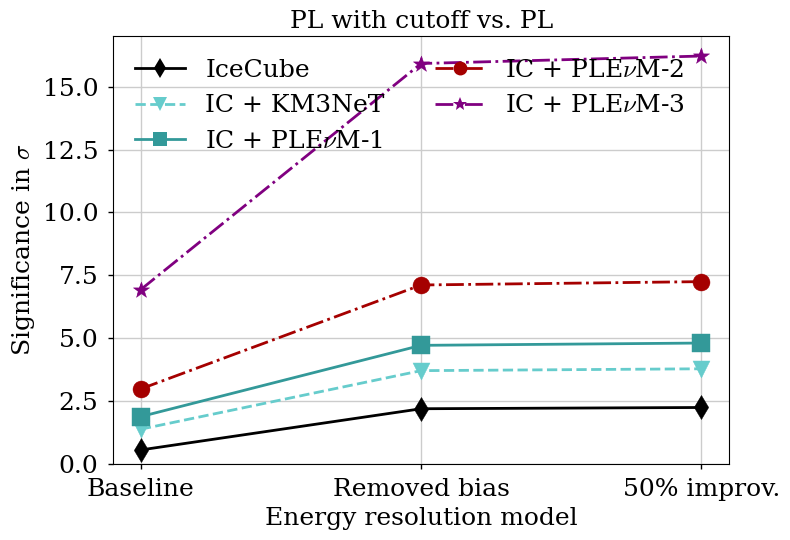

In [48]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby("key"):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, None)
ax.legend(loc=2, ncol=2, frameon=False)  # , fontsize="large")
ax.set_title("PL with cutoff vs. PL")  # , fontsize=18)
ax.set_xlabel("Energy resolution model")  # , fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$")  # , fontsize=18)
f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/cutoff_sigma_vs_eres_ngc.pdf"))

In [49]:
pval_df.loc[pval_df.e_smearing=="Baseline"]

,identifier,key,e_smearing,pval,Significance in $\sigma$
0,IceCube,IceCube,Baseline,2.898844e-01,0.553723
3,IC + KM3NeT,KM3NeT,Baseline,8.407963e-02,1.378143
6,IC + PLE$\nu$M-1,Plenum-1,Baseline,3.004690e-02,1.880105
9,IC + PLE$\nu$M-2,Plenum-2,Baseline,1.437439e-03,2.980809
12,IC + PLE$\nu$M-3,Plenum-3,Baseline,2.082200e-12,6.931487


## spectral fit vs. dec

scan for right threshold

In [50]:
np.sort(np.concatenate([np.rad2deg(np.arcsin(np.linspace(-1, 1, 30))), np.linspace(-4.9, 0, num=5)]))

array([-90.        , -68.59665036, -59.54968598, -52.4764868 ,
       -46.39718103, -40.93272457, -35.88829755, -31.14738992,
       -26.63311875, -22.29097037, -18.08001262, -13.96796267,
        -9.92819184,  -5.93777245,  -4.9       ,  -3.675     ,
        -2.45      ,  -1.97610829,  -1.225     ,   0.        ,
         1.97610829,   5.93777245,   9.92819184,  13.96796267,
        18.08001262,  22.29097037,  26.63311875,  31.14738992,
        35.88829755,  40.93272457,  46.39718103,  52.4764868 ,
        59.54968598,  68.59665036,  90.        ])

In [51]:
# for paper
detector_keys = [
    "IceCube",
    IC_North_det ,
    IC_North_det + "-only",
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]
# decs = np.arange(-90, 91, step=10)
decs = np.sort(np.concatenate([np.rad2deg(np.arcsin(np.linspace(-1, 1, 30))), np.linspace(-4.9, 0, num=5)]))

thresholds = [sigma3] #, 0.01, 0.1]
for ident in detector_keys:
    tmp = []
    conf = st.detector_configurations[ident]
    print(conf)
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_cut_flux,
        )
        if np.isclose(np.sum(all_k_s), 0):
            continue

        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)

        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
            )

            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(1e-4, 10), (1e-4, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
                approx_grad=True,
            )
            pval = chi2.sf(
                out_bckg[1] - global_llh((1, scaler, st.Gamma_cut, st.logE_cut)), 1
            )
            # pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_sig": np.sum(current_k_s),
                "out_bg": out_bckg,
                # "out_comp": out_comp,
                "log10(p)": -np.log10(pval),
                "pval": pval,
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

    df = pd.DataFrame(tmp)
    df.to_pickle(join(BASEPATH, f"resources/ngc_spectral_disc_pot_{ident}.pickle"))

(['IceCube'], [1.4])


  0%|          | 0/35 [00:00<?, ?it/s]

 97%|█████████▋| 34/35 [00:06<00:00,  3.11it/s]

end of range
end of range
end of range


100%|██████████| 35/35 [00:07<00:00,  4.97it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:18<00:00,  1.52it/s]

end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:19<00:00,  1.82it/s]


(['KM3NeT'], [1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range


100%|██████████| 35/35 [00:10<00:00,  3.42it/s]


end of range
end of range
end of range
(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:39<00:01,  1.10s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:40<00:00,  1.15s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [00:44<00:00,  1.02it/s]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [00:45<00:00,  1.29s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


  0%|          | 0/35 [00:00<?, ?it/s]

low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range
low end range


 97%|█████████▋| 34/35 [01:09<00:01,  1.71s/it]

end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range
end of range


100%|██████████| 35/35 [01:10<00:00,  2.00s/it]


In [52]:
# thresholds = [sigma3, 0.01, 0.1]
# xname = "SosB"  # "scaler" #
# ax = sns.lineplot(data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
# for t in thresholds:
#     plt.axhline(-np.log10(t), ls=":")
# plt.legend()

## plotting


In [53]:
flux = []
for ident in detector_keys:
    
    df = pd.read_pickle(join(BASEPATH, f"resources/ngc_spectral_disc_pot_{ident}.pickle"))
    _flux = pd.DataFrame(
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
        * ngc_cut_flux.norm,
        columns=["sigma3"],
    )
    _flux["1%"] = (
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
        * ngc_cut_flux.norm
    )
    _flux["5%"] = (
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
        * ngc_cut_flux.norm
    )
    _flux["10%"] = (
        df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
    )
    flux.append( _flux.reset_index())

flux = pd.concat(flux)
flux.to_pickle(join(st.BASEPATH, "resources/flux_ngc_spectral_disc_pot.pickle"))
flux


,ident,dec,sigma3,1%,5%,10%
0,IceCube,-0.085521,3.724548e-13,2.477333e-13,1.693326e-13,1.341562e-13
1,IceCube,-0.064141,1.970914e-13,1.349376e-13,9.475535e-14,7.632086e-14
2,IceCube,-0.042761,1.594361e-13,1.102878e-13,7.819423e-14,6.335343e-14
3,IceCube,-0.034490,1.505922e-13,1.044464e-13,7.423588e-14,6.023739e-14
4,IceCube,-0.021380,1.395376e-13,9.713352e-14,6.927397e-14,5.632854e-14
...,...,...,...,...,...,...
30,Plenum-3,0.809784,1.613518e-14,1.164026e-14,8.582957e-15,7.122839e-15
31,Plenum-3,0.915887,1.625732e-14,1.171305e-14,8.626102e-15,7.153302e-15
32,Plenum-3,1.039338,1.683839e-14,1.210713e-14,8.899474e-15,7.371460e-15
33,Plenum-3,1.197237,1.818344e-14,1.301838e-14,9.531140e-15,7.875390e-15


Text(0.5, 0.98, 'Spectral discrimination: \n PL vs. PL with cutoff')

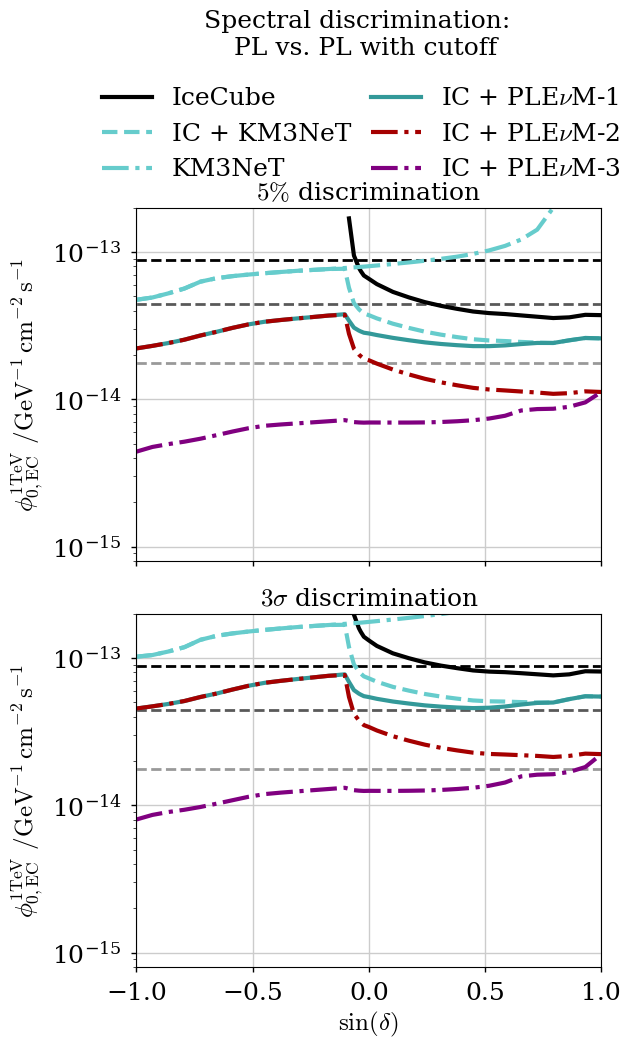

In [54]:

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-16, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
# )
# see plotting_standalone.ipynb for final version

Text(0.12, 0.98, 'Spectral discrimination: PL vs. PL with cutoff')

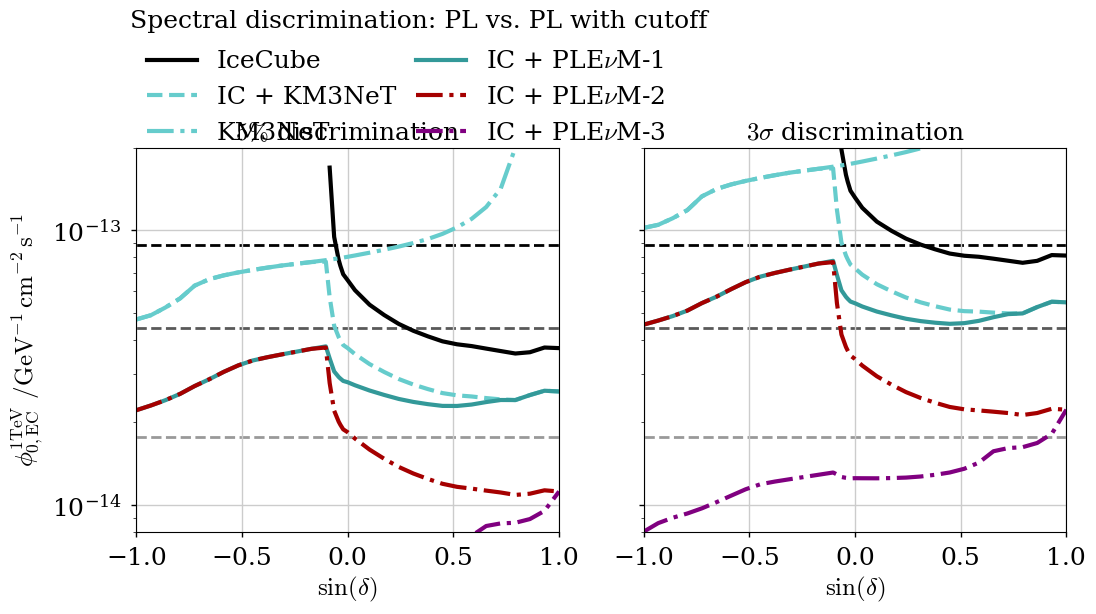

In [55]:

### plot various thresholds
f, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r"$\sin(\delta)$", fontsize=18)
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.35, 0.95),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[0].set_ylabel(
    r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=18,
)
f.subplots_adjust(hspace=0.15, top=0.75)
f.suptitle("Spectral discrimination: PL vs. PL with cutoff", fontsize=18, ha="left", x=0.12)
# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot_horizontal.pdf"),
#     bbox_inches="tight",
# )
# see plotting_standalone.ipynb for final version